In [1]:
from __future__ import print_function
import importlib
from distutils.version import LooseVersion
import glob
import numpy as np
import os
import SimpleITK as sitk
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
def myshow(img, title=None, margin=0.05, dpi=80):
    nda = sitk.GetArrayViewFromImage(img)
    spacing = img.GetSpacing()
        
    if nda.ndim == 3:
        # fastest dim, either component or x
        c = nda.shape[-1]
        
        # the the number of components is 3 or 4 consider it an RGB image
        if not c in (3,4):
            nda = nda[nda.shape[0]//2,:,:]
    
    elif nda.ndim == 4:
        c = nda.shape[-1]
        
        if not c in (3,4):
            raise Runtime("Unable to show 3D-vector Image")
            
        # take a z-slice
        nda = nda[nda.shape[0]//2,:,:,:]
            
    ysize = nda.shape[0]
    xsize = nda.shape[1]
      
    # Make a figure big enough to accommodate an axis of xpixels by ypixels
    # as well as the ticklabels, etc...
    figsize = (1 + margin) * ysize / dpi, (1 + margin) * xsize / dpi

    fig = plt.figure(figsize=figsize, dpi=dpi)
    # Make the axis the right size...
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])
    
    extent = (0, xsize*spacing[1], ysize*spacing[0], 0)
    
    t = ax.imshow(nda,extent=extent,interpolation=None)
    
    if nda.ndim == 2:
        t.set_cmap("gray")
    
    if(title):
        plt.title(title)

In [3]:
help(np.pad)

Help on function pad in module numpy.lib.arraypad:

pad(array, pad_width, mode, **kwargs)
    Pads an array.
    
    Parameters
    ----------
    array : array_like of rank N
        Input array
    pad_width : {sequence, array_like, int}
        Number of values padded to the edges of each axis.
        ((before_1, after_1), ... (before_N, after_N)) unique pad widths
        for each axis.
        ((before, after),) yields same before and after pad for each axis.
        (pad,) or int is a shortcut for before = after = pad width for all
        axes.
    mode : str or function
        One of the following string values or a user supplied function.
    
        'constant'
            Pads with a constant value.
        'edge'
            Pads with the edge values of array.
        'linear_ramp'
            Pads with the linear ramp between end_value and the
            array edge value.
        'maximum'
            Pads with the maximum value of all or part of the
            vector

In [18]:
def loadData( rootPath, padding=0 ):
    imageFilenames = glob.glob(os.path.join(rootPath, "*", "pre", "T1.nii.gz"))      
    flairFilenames = glob.glob(os.path.join(rootPath, "*", "pre", "FLAIR.nii.gz"))
    labelFilenames = glob.glob(os.path.join(rootPath, "*", "wmh.nii.gz"))
    
    images = None # shape: (numImages, z, y, x, channels=1)
    labels = None
    masks  = None
    for imageFilename, flairFilename, labelFilename in zip(imageFilenames, flairFilenames, labelFilenames):
        # Load the images
        imageImage = sitk.ReadImage(imageFilename)
        flairImage = sitk.ReadImage(flairFilename)
        labelImage = sitk.ReadImage(labelFilename)
        # Convert to arrays
        imageArray = np.pad(sitk.GetArrayFromImage(imageImage), [(0,0),(padding,padding),(padding,padding)], 'constant')
        flairArray = np.pad(sitk.GetArrayFromImage(flairImage), [(0,0),(padding,padding),(padding,padding)], 'constant')
        labelArray = np.pad(sitk.GetArrayFromImage(labelImage), [(0,0),(padding,padding),(padding,padding)], 'constant')
        maskArray = labelArray > 0
        
        # Add to the images/labels array
        if images is None:
            images = imageArray.reshape([1] + list(imageArray.shape) + [1])
            images = np.concatenate([images, flairArray.reshape([1] + list(flairArray.shape) + [1])], axis=4)
            labels = labelArray.reshape([1] + list(labelArray.shape) + [1])
            masks  = maskArray.reshape([1] + list(maskArray.shape) + [1])
        else:
            tempArray = np.concatenate([imageArray.reshape([1] + list(imageArray.shape) + [1]), flairArray.reshape([1] + list(flairArray.shape) + [1])], axis=4)
            images = np.concatenate([images, tempArray])
            
            labels = np.concatenate([labels, labelArray.reshape([1] + list(labelArray.shape) + [1])])
            masks  = np.concatenate([masks, maskArray.reshape([1] + list(maskArray.shape) + [1])])
    
    size = flairImage.GetSize()
    print(size)
    nslices = 3
    slices = [ flairImage[:,:,s] for s in range(0, size[2], size[2]//10)]
    myshow(sitk.Tile(slices, [10,100]))                
    
    return images, labels, masks

(132, 256, 83)


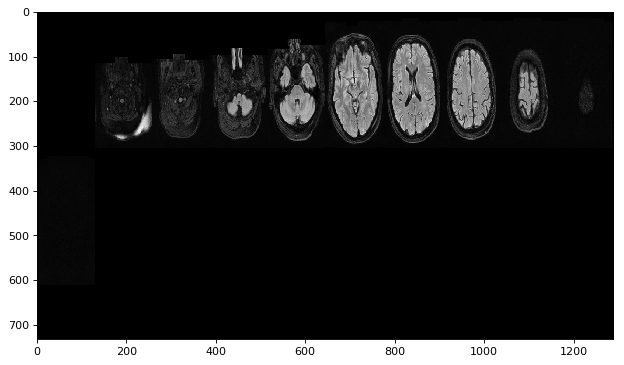

In [29]:
rootPath = "../data/train/Amsterdam"
testPath = "../data/train/Amsterdam"
testImages, testLabels, testMasks = loadData(testPath)
testNonZeroIdx = np.nonzero(testLabels)

In [30]:
testNonZeroIdx

(array([ 0,  0,  0, ..., 14, 14, 14], dtype=int64),
 array([32, 32, 32, ..., 61, 62, 62], dtype=int64),
 array([215, 215, 216, ..., 151, 132, 133], dtype=int64),
 array([79, 80, 79, ..., 84, 64, 64], dtype=int64),
 array([0, 0, 0, ..., 0, 0, 0], dtype=int64))

In [20]:
testImages.shape

(15, 83, 256, 132, 2)

In [21]:
testLabels.shape

(15, 83, 256, 132, 1)

In [22]:
testMasks.shape

(15, 83, 256, 132, 1)

In [23]:
type(testImages)

numpy.ndarray

In [24]:
import random
random.sample(range(20), 10)

[5, 3, 11, 10, 18, 12, 15, 17, 14, 6]

In [25]:
import os
path=os.path.dirname("train/Amsterdam/GE3T")
print(path)
print(os.path.basename(path))


train/Amsterdam
Amsterdam


In [26]:
listOfFiles = os.listdir("train/Utrecht")
result = [i for i in listOfFiles if not i.startswith('.')]
print(len(result))
print(result)
random.seed(88)
random.sample(result, 5)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'train/Utrecht'